<p style="font-size:300%; text-align:center"> king county housing price modeling</p>
<p style="font-size:150%; text-align:center"> Feature selection and validation</p>

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium 
import statsmodels.api as sm
from statsmodels.formula.api import ols
plt.style.use('ggplot')

##  Read the clean normalized KC housing data

In [2]:
kc_final = pd.read_csv('data/kc_house_data_normalized.csv')
kc_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21398 entries, 0 to 21397
Data columns (total 21 columns):
id               21398 non-null float64
bedrooms         21398 non-null float64
bathrooms        21398 non-null float64
sqft_living      21398 non-null float64
sqft_lot         21398 non-null float64
floors           21398 non-null float64
view             21398 non-null float64
condition        21398 non-null float64
grade            21398 non-null float64
sqft_basement    21398 non-null float64
yr_built         21398 non-null float64
zipcode          21398 non-null float64
lat              21398 non-null float64
long             21398 non-null float64
sqft_living15    21398 non-null float64
sqft_lot15       21398 non-null float64
waterfront_1     21398 non-null float64
season_spring    21398 non-null float64
season_summer    21398 non-null float64
season_fall      21398 non-null float64
price            21398 non-null float64
dtypes: float64(21)
memory usage: 3.4 MB


## Manual feature selection 
Since there is only few features. I can attempt to manually select the features. 

In [3]:
tmp_kc = kc_final.drop(['id'], axis=1)
tmp_kc.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'view',
       'condition', 'grade', 'sqft_basement', 'yr_built', 'zipcode', 'lat',
       'long', 'sqft_living15', 'sqft_lot15', 'waterfront_1', 'season_spring',
       'season_summer', 'season_fall', 'price'],
      dtype='object')

In [4]:
# Add and substract features to get the best adjusted R2 value.  
# since 'grade' has the highest R2 it's a good place to start
tmp_kc = kc_final.drop(["id"], axis=1) # remove id
predictors = ['grade', 'sqft_living' , 'sqft_living15', 'lat', 'bedrooms', 'sqft_basement','long', 'condition']
predictors = predictors + ['zipcode', 'yr_built', 'view', 'waterfront_1', 'sqft_lot']
predictors = predictors + ['season_spring', 'season_summer', 'season_fall', 'floors', 'bathrooms']

f = 'price ~ ' + ' + '.join(predictors)       
model = ols(formula=f, data=tmp_kc).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     3583.
Date:                Wed, 06 May 2020   Prob (F-statistic):               0.00
Time:                        02:29:01   Log-Likelihood:                -674.93
No. Observations:               21398   AIC:                             1388.
Df Residuals:                   21379   BIC:                             1539.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        11.4274      0.015    742.716

## Stepwise feature selection 

In [5]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [6]:
predictors=kc_final.drop(['id', 'price'], axis=1)
target=kc_final[["price"]]
result = stepwise_selection(predictors, target, verbose=True)
print('resulting features:')

Add  bedrooms                       with p-value 0.0


C:\Anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Add  sqft_living15                  with p-value 0.0
Add  bathrooms                      with p-value 0.0
Add  sqft_living                    with p-value 0.0
Add  yr_built                       with p-value 0.0
Add  grade                          with p-value 0.0
Add  lat                            with p-value 0.0
Add  view                           with p-value 1.76062e-171
Add  condition                      with p-value 3.17654e-87
Add  floors                         with p-value 1.09778e-65
Add  waterfront_1                   with p-value 1.91719e-42
Add  zipcode                        with p-value 1.18578e-36
Add  long                           with p-value 4.66138e-15
Add  sqft_lot                       with p-value 2.45828e-17
Add  season_spring                  with p-value 4.3987e-12
Add  sqft_basement                  with p-value 8.11839e-05
resulting features:


In [7]:
print(result)

['bedrooms', 'sqft_living15', 'bathrooms', 'sqft_living', 'yr_built', 'grade', 'lat', 'view', 'condition', 'floors', 'waterfront_1', 'zipcode', 'long', 'sqft_lot', 'season_spring', 'sqft_basement']


In [8]:
# What's the regression of most optimal features after recursive feature selection ? 
tmp_kc = kc_final.drop(["id"], axis=1) # remove id
predictors = list(tmp_kc.columns)
predictors.remove('price')

f = 'price ~ ' + ' + '.join(predictors)       
model = ols(formula=f, data=tmp_kc).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     3396.
Date:                Wed, 06 May 2020   Prob (F-statistic):               0.00
Time:                        02:29:04   Log-Likelihood:                -671.72
No. Observations:               21398   AIC:                             1383.
Df Residuals:                   21378   BIC:                             1543.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        11.4277      0.015    742.810

## Validation 


### Regression diagnostics

#### Normality Check (Q-Q plots)

C:\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\graphics\utils.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
C:\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()


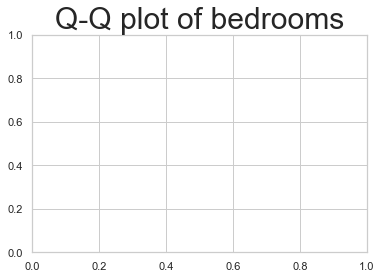

<Figure size 720x720 with 0 Axes>

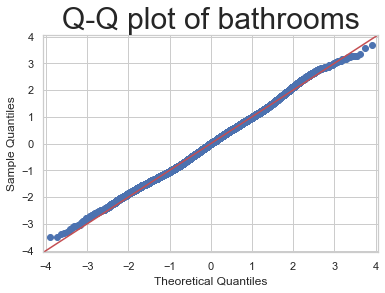

<Figure size 720x720 with 0 Axes>

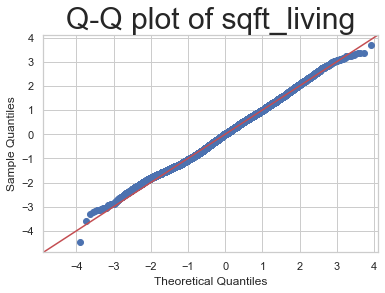

<Figure size 720x720 with 0 Axes>

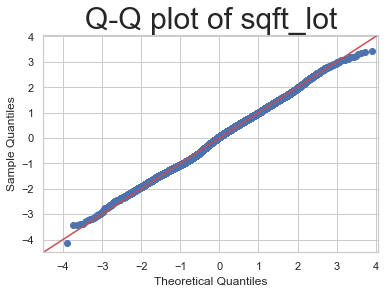

<Figure size 720x720 with 0 Axes>

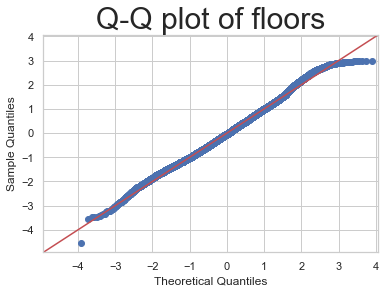

<Figure size 720x720 with 0 Axes>

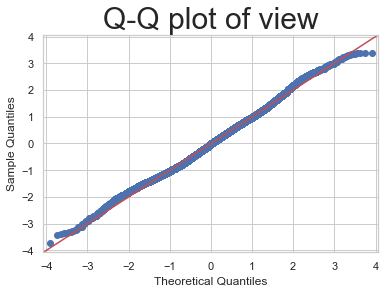

<Figure size 720x720 with 0 Axes>

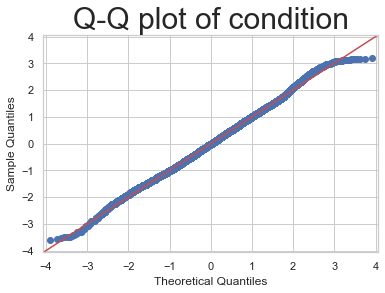

<Figure size 720x720 with 0 Axes>

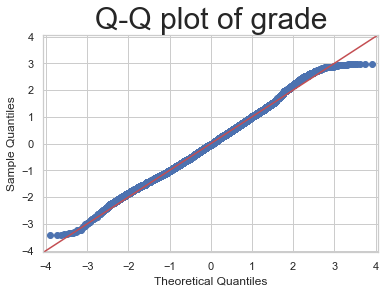

<Figure size 720x720 with 0 Axes>

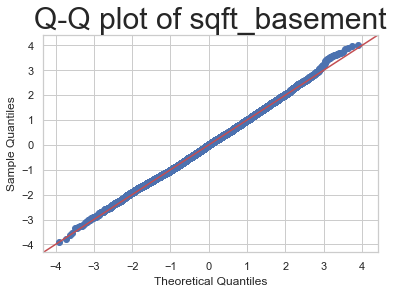

<Figure size 720x720 with 0 Axes>

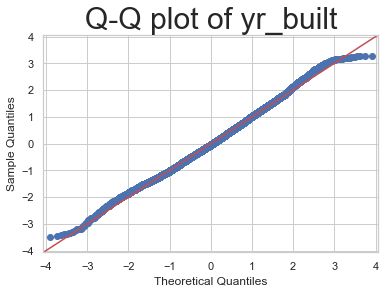

<Figure size 720x720 with 0 Axes>

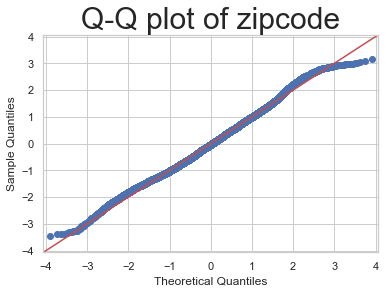

<Figure size 720x720 with 0 Axes>

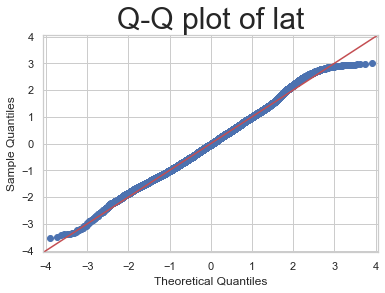

<Figure size 720x720 with 0 Axes>

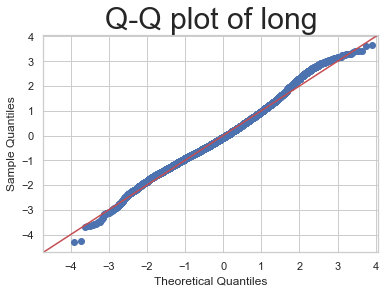

<Figure size 720x720 with 0 Axes>

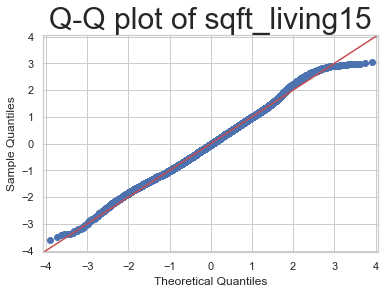

<Figure size 720x720 with 0 Axes>

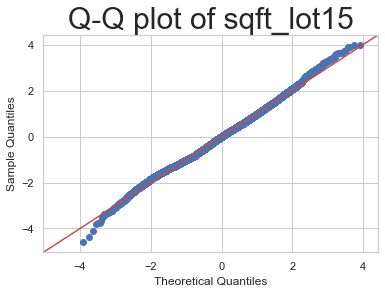

<Figure size 720x720 with 0 Axes>

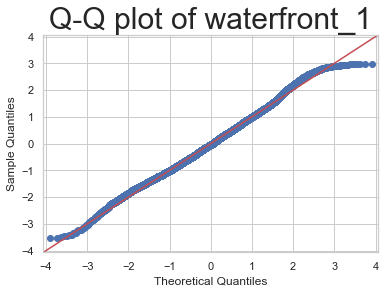

<Figure size 720x720 with 0 Axes>

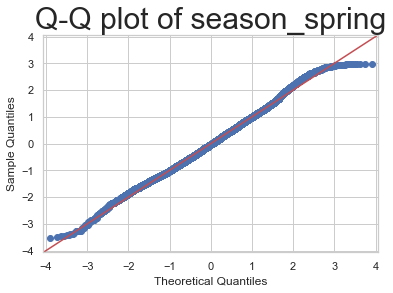

<Figure size 720x720 with 0 Axes>

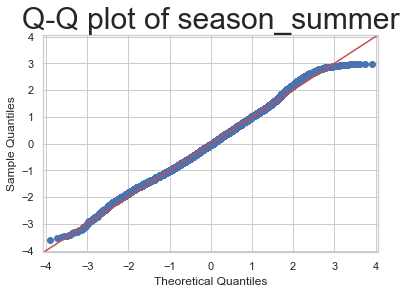

<Figure size 720x720 with 0 Axes>

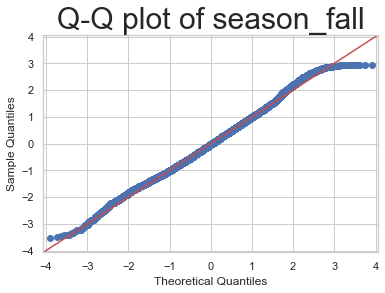

<Figure size 720x720 with 0 Axes>

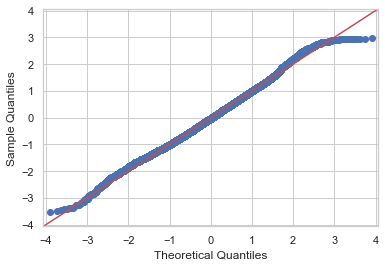

In [9]:
import statsmodels.stats.api as sms
import scipy.stats as stats
sns.set(style="whitegrid")

tmp_kc = kc_final.drop(["id"], axis=1) # remove id
predictors = list(tmp_kc.columns)
predictors.remove('price')

for i in range(len(predictors)):
    #print("formula = price ~ "+predictors[i])
    f = 'price ~ ' + predictors[i]       
    model = ols(formula=f, data=tmp_kc).fit()
    # get residue
    resid = model.resid
    plt.title('Q-Q plot of '+predictors[i],fontsize=30)
    fig = plt.figure(figsize=(10,10))
    fig = sm.graphics.qqplot(resid, dist=stats.norm, line='45', fit=True)
    #plt.show()

Q-Q plots look good. Normality is preserved in all features. 

### Test-Train split - mean squard error 

In [10]:
#result.remove('view')
print(result)

['bedrooms', 'sqft_living15', 'bathrooms', 'sqft_living', 'yr_built', 'grade', 'lat', 'view', 'condition', 'floors', 'waterfront_1', 'zipcode', 'long', 'sqft_lot', 'season_spring', 'sqft_basement']


In [11]:
# 'view' still have a high p-values. So removed from the analysis
tmp_y = kc_final[["price"]]
tmp_X = kc_final[result]
y = tmp_y.iloc[:,0].values
X = tmp_X.iloc[:,0:].values

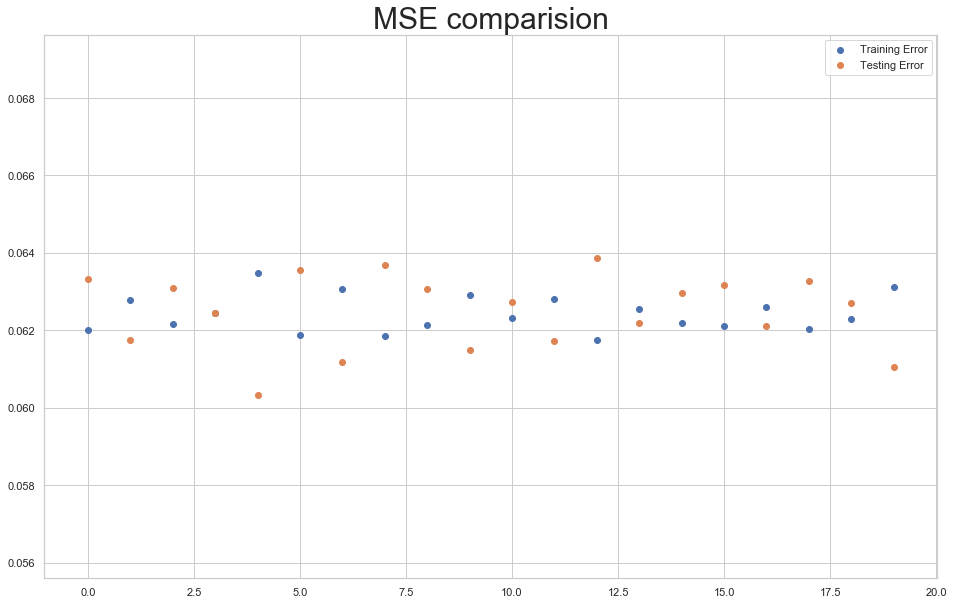

In [12]:
# RMS error with scikit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
import matplotlib.pyplot as plt
%matplotlib inline

num = 20
train_err = []
test_err = []
for i in range(num):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    linreg.fit(X_train, y_train)
    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)
    train_err.append(mean_squared_error(y_train, y_hat_train))
    test_err.append(mean_squared_error(y_test, y_hat_test))

    
sns.set(style="whitegrid")
plt.figure(figsize=(16,10))
plt.title('MSE comparision',fontsize=30)
plt.scatter(list(range(num)), train_err, label='Training Error')
plt.scatter(list(range(num)), test_err, label='Testing Error')
plt.legend()
plt.savefig('img/Train_Test_error.png') # Save that figure
plt.show()

### K-fold cross validation 

In [13]:
from sklearn.model_selection import cross_val_score

cv_5_results  = np.mean(cross_val_score(linreg, X, y, cv=5,  scoring='neg_mean_squared_error'))
print("cv_5 MSE = ", cv_5_results)
cv_10_results = np.mean(cross_val_score(linreg, X, y, cv=10, scoring='neg_mean_squared_error'))
print("cv_10 MSE = ", cv_10_results)
cv_20_results = np.mean(cross_val_score(linreg, X, y, cv=20, scoring='neg_mean_squared_error'))
print("cv_20 MSE = ", cv_20_results)
cv_40_results = np.mean(cross_val_score(linreg, X, y, cv=40, scoring='neg_mean_squared_error'))
print("cv_40 MSE = ", cv_40_results)

cv_5 MSE =  -0.06311473942897024
cv_10 MSE =  -0.06301052498427041
cv_20 MSE =  -0.06271430614026068
cv_40 MSE =  -0.06262657518405772


## comparison of real and predicted 

In [14]:
# read back real price values from cleaned data
kc_clean = pd.read_csv('data/kc_house_data_clean.csv')
kc_real = kc_clean[['price']]
y_real_log = np.log(kc_real.iloc[:,0].values)

# read X to creat Y_predicted from X
kc_predict = kc_final[['price']+result]
X_train = kc_predict.drop('price', axis =1 )

# Create OLS model and summary and constants 
ols_model = sm.OLS(y_real_log, sm.add_constant(X_train), hasconst= True)
model = ols_model.fit()
#train_results = model.summary()

y_pred = model.predict(sm.add_constant(X_train))


C:\Anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


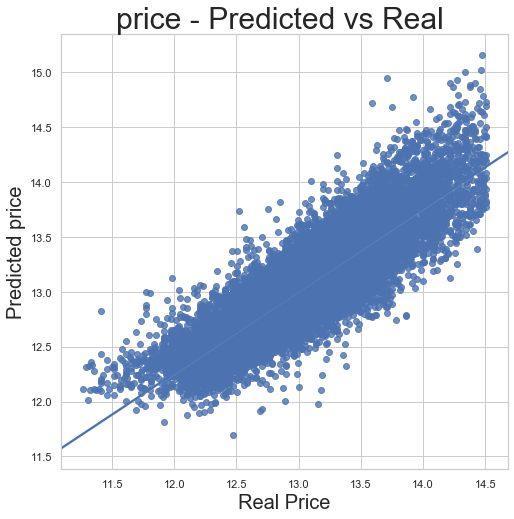

In [15]:
# Plot predicted values
sns.set(style="whitegrid")   
#fig, ax = plt.subplots(figsize=(8, 8))

plt.figure(figsize=(8,8))
plt.title('price - Predicted vs Real ',fontsize=30)
ax = sns.regplot(x=y_real_log, y=y_pred);
ax.set_xlabel('Real Price', fontsize=20)
ax.set_ylabel("Predicted price", fontsize=20)

plt.savefig('img/Pred_vs_real.png') # Save that figure
plt.show()


## Visualizing relationship of the "price" with final features 

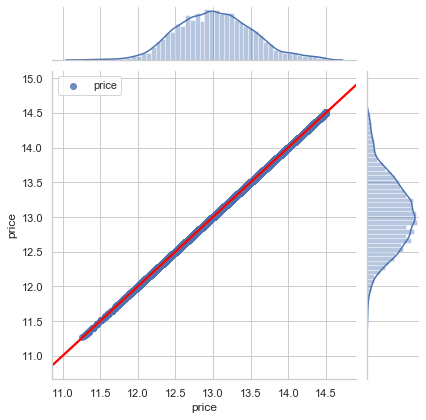

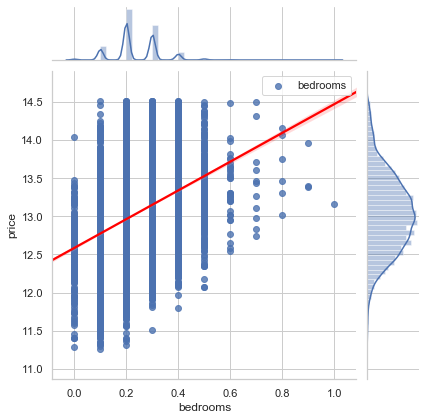

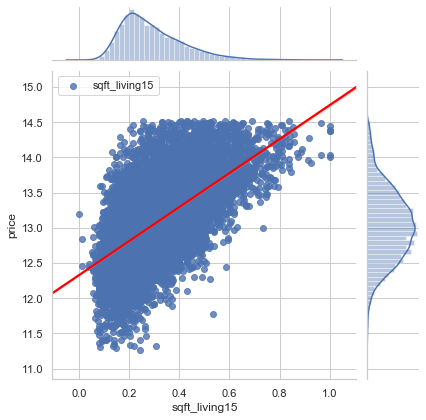

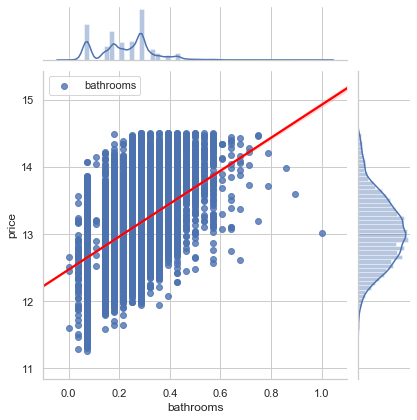

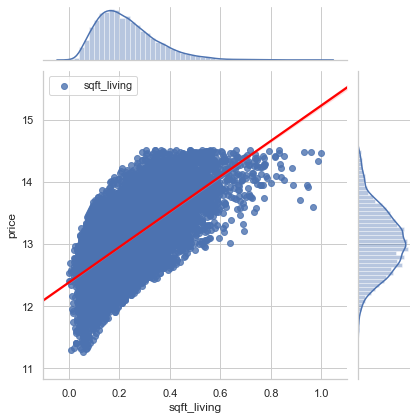

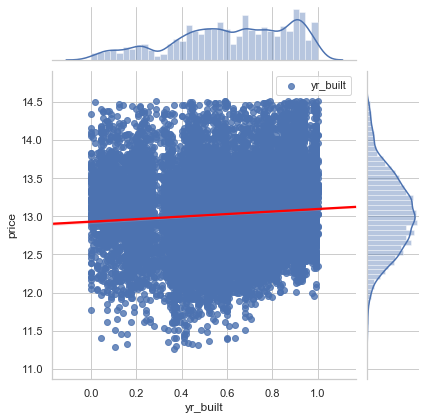

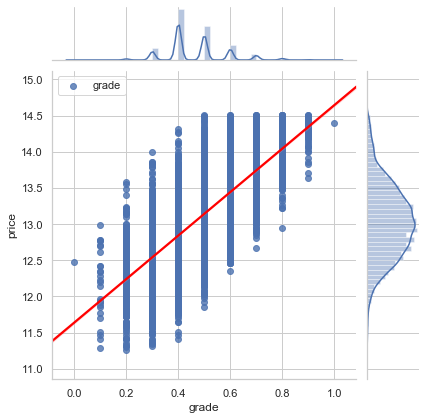

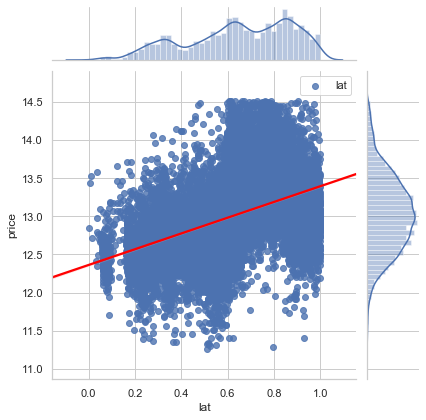

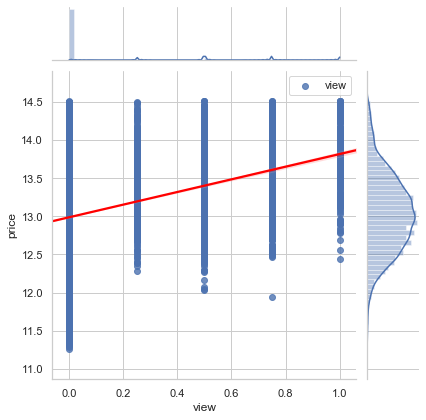

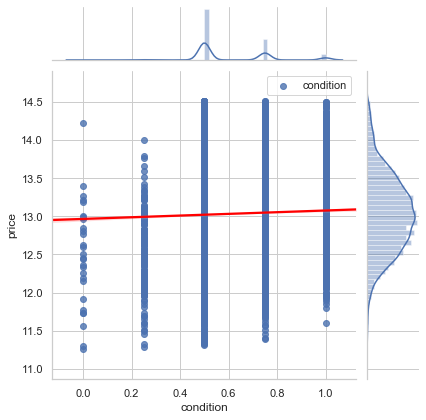

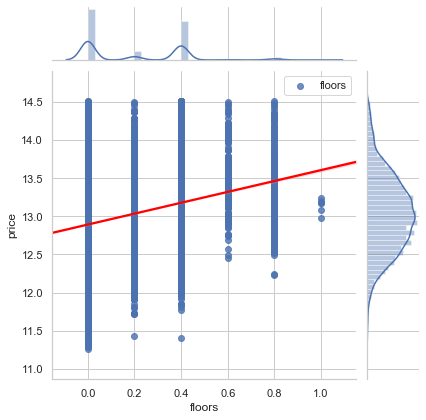

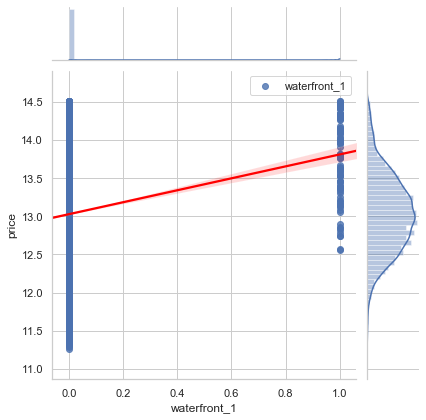

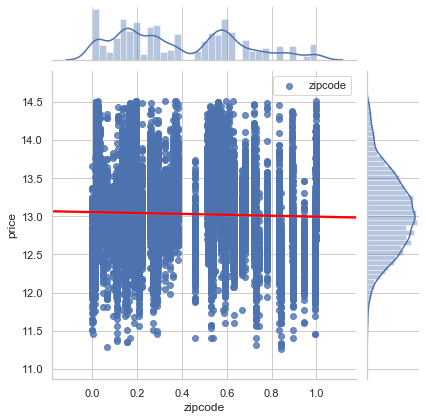

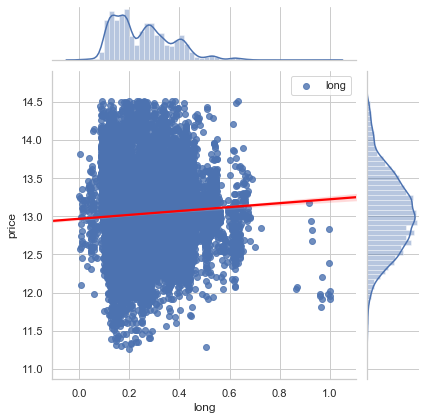

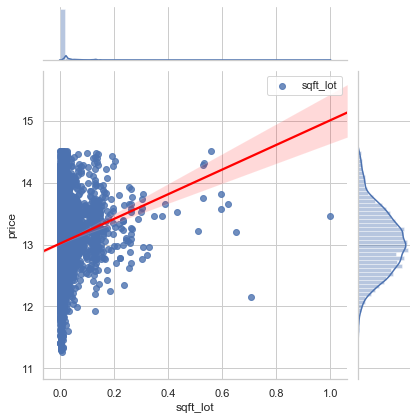

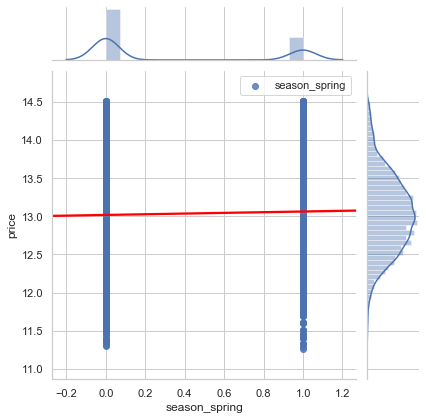

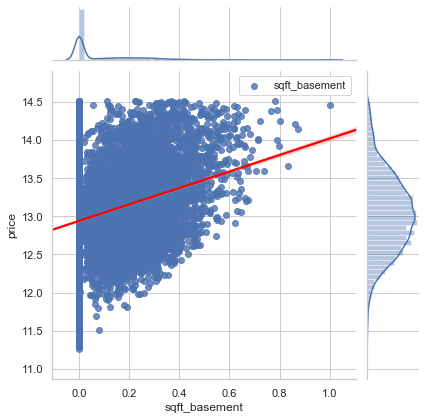

In [16]:
tmp_kc = kc_final[['price']+result]

headers=tmp_kc.columns

#once again just iterating through our list of columns so that we get each separate plot
for column in headers:
    sns.jointplot(x=column, y="price", #creating our joint plot as well as setting our columns to be predictors and price to be our target
                  data=tmp_kc, #we want the jointplots to be created using our df_price_log dataset
                  kind='reg', 
                  label=column, 
                  joint_kws={'line_kws':{'color':'red'}}) #stylistic choices

    plt.legend() #including a legend for our plots
    if column == 'grade':
        plt.savefig('img/grade_jointplot.png') # Save that figure
    plt.show()

## All data is validated and ready for further analysis
Save the clean data to a kc_house_data_clean.csv file

In [17]:
#print(result)
kc_final = kc_final[result]

In [18]:
kc_final.to_csv('data/kc_house_data_validated.csv', index=False)

<p style="font-size:200%; text-align:center">Please open analysis.ipynb next for further analysis</p>